In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle

In [2]:
df = pd.read_excel('../data/NBAStats.xlsx').set_index('PLAYER')
df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
df = df.astype(float)

Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [3]:
dfPlayerCol = df.reset_index()

In [4]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [5]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.430279295609192
Variance with 3 components: 0.5310231474672943
Variance with 4 components: 0.6278640771667467
Variance with 5 components: 0.6813777704897697
Variance with 6 components: 0.7277244370552364
Variance with 7 components: 0.762731063783529
Variance with 8 components: 0.7937961307015966
Variance with 9 components: 0.8191486048414107
Variance with 10 components: 0.8436267679513352
Variance with 11 components: 0.8648206200403661
Variance with 12 components: 0.8852979865317814
Variance with 13 components: 0.9015949016677292
Variance with 14 components: 0.916965726568756
Variance with 15 components: 0.9312361938074414
Variance with 16 components: 0.9429949242181316
Variance with 17 components: 0.9536668475013592
Variance with 18 components: 0.9627623733777307
Variance with 19 components: 0.9709602127072232
Variance with 20 components: 0.9773386775813357
Variance with 21 components: 0.9821299105544045
Variance with 22 components: 0.9863226494378744
Var

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

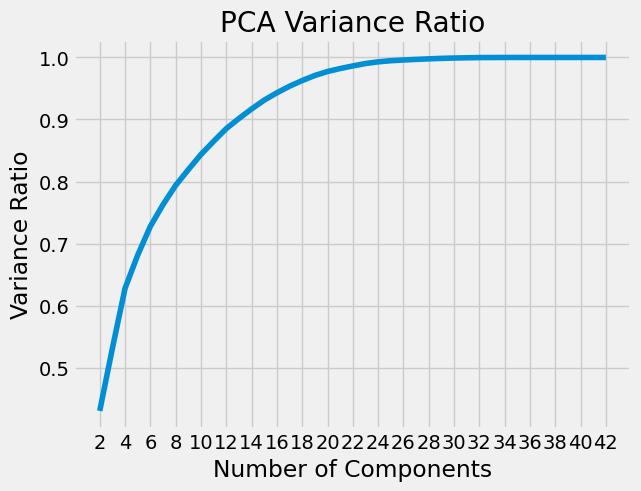

In [6]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [7]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.00743852e-01 9.68409297e-02 5.35136933e-02 4.63466666e-02
 3.50066267e-02 3.10650669e-02 2.53524741e-02 2.44781631e-02
 2.11938521e-02 2.04773665e-02 1.62969151e-02 1.53708249e-02
 1.42704672e-02 1.17587304e-02 1.06719233e-02 9.09552588e-03
 8.19783933e-03 6.37846487e-03 4.79123297e-03 4.19273888e-03
 3.86759185e-03 2.73053266e-03 1.83644311e-03 1.15085503e-03
 9.67892332e-04 8.77424021e-04 7.79688501e-04 5.39671976e-04
 4.01645929e-04 3.10487066e-04 1.09004309e-04 8.73018693e-05
 1.82030178e-05 5.20066375e-07 8.01307810e-08 5.73586623e-09
 2.10175166e-09 8.52949045e-10 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

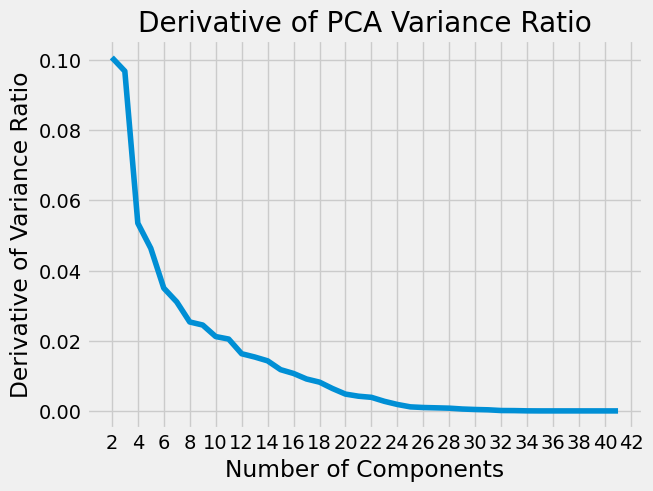

In [8]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [9]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.22520434 0.20507496 0.10074385 0.09684093 0.05351369 0.04634667
 0.03500663 0.03106507 0.02535247 0.02447816 0.02119385 0.02047737
 0.01629692 0.01537082 0.01427047 0.01175873]
0.9429949242181316


In [10]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.2238818831847
Silhouette Score with 3 clusters: 0.1867579452891128
Silhouette Score with 4 clusters: 0.13326016835950633
Silhouette Score with 5 clusters: 0.1265189628752981
Silhouette Score with 6 clusters: 0.11519871742058113
Silhouette Score with 7 clusters: 0.10875870106943161
Silhouette Score with 8 clusters: 0.11265551354162227
Silhouette Score with 9 clusters: 0.10181961793420254
Silhouette Score with 10 clusters: 0.0965341173460467
Silhouette Score with 11 clusters: 0.09500264768494751
Silhouette Score with 12 clusters: 0.08953885034121344
Silhouette Score with 13 clusters: 0.08838145334934167
Silhouette Score with 14 clusters: 0.08415579187502951
Silhouette Score with 15 clusters: 0.0800401210459645
Silhouette Score with 16 clusters: 0.08074156407527336
Silhouette Score with 17 clusters: 0.07679898178579361
Silhouette Score with 18 clusters: 0.07408905798123398
Silhouette Score with 19 clusters: 0.0745835085186483
Silhouette Score with 20 cl

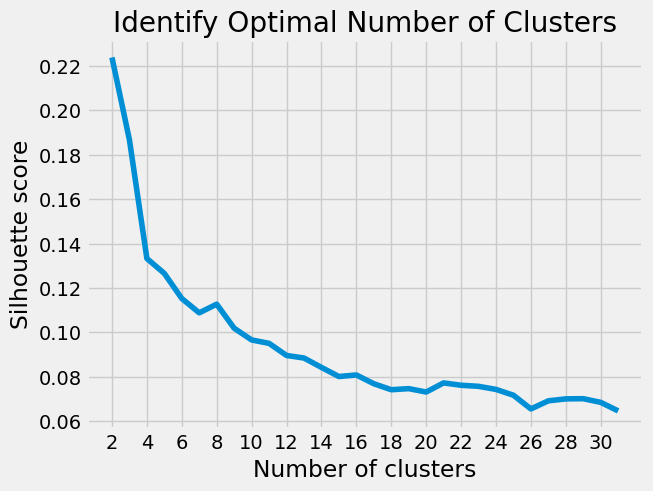

In [11]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [12]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = -0.047832845402347335
for n_cluseter = 4, improvement = -0.06578333796156843
for n_cluseter = 5, improvement = -0.007777657421661255
for n_cluseter = 6, improvement = -0.012959921250243367
for n_cluseter = 7, improvement = -0.007278488942031425
for n_cluseter = 8, improvement = 0.004372342795230133
for n_cluseter = 9, improvement = -0.012211599635524317
for n_cluseter = 10, improvement = -0.005884676055826654
for n_cluseter = 11, improvement = -0.0016951051395548422
for n_cluseter = 12, improvement = -0.006037362794219403
for n_cluseter = 13, improvement = -0.0012712206251805913
for n_cluseter = 14, improvement = -0.004635339517649717
for n_cluseter = 15, improvement = -0.004493854732663616
for n_cluseter = 16, improvement = 0.0007624713265825811
for n_cluseter = 17, improvement = -0.004288872568804614
for n_cluseter = 18, improvement = -0.0029353561695604213
for n_cluseter = 19, improvement = 0.000534015222172668
for n_cluseter = 20, improvement = -0.

C:\conda_tmp\ipykernel_31848\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


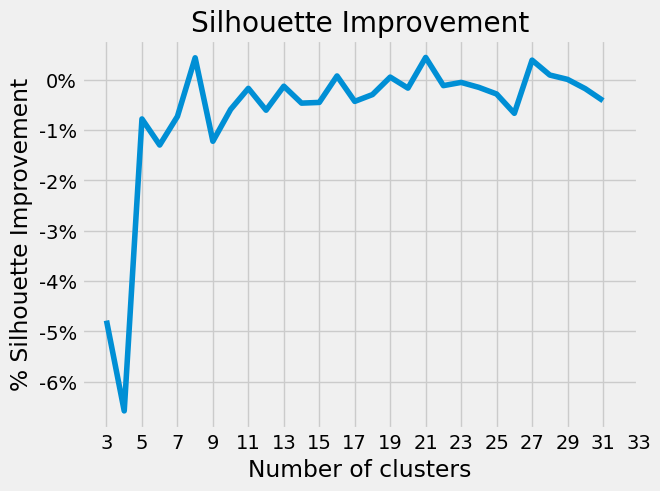

In [13]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [14]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [15]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,Bennedict Mathurin,5
1,Clint Capela,0
2,De'Aaron Fox,7
3,Jarace Walker,12
4,Jaylen Wells,5


In [17]:
pd.DataFrame.to_excel(df_cluster, '../data/clusteredPlayers.xlsx')